# Tom and Jerry Image Classification
https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification

## Import libraries

In [891]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import os
import squarify
from skimage.feature import graycomatrix, graycoprops


# import statsmodels.api as sm
# import networkx as nx
# import seaborn as sns

import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input


# import matplotlib.image as mpimg

## Function to extract features of an image

### General function

## Initialize

In [892]:
data_dir = './kaggle/input/tom_and_jerry/tom_and_jerry'
image_size = (224, 224)

data = []
labels = []


subfolders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

label_categories = ["Jerry","Tom","None","Both"]

### Tom & Jerry Label Balance

Jerry: 1240  Tom: 1930  None: 1528  Both: 780  

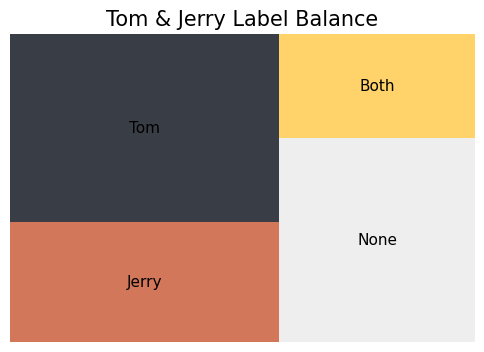

In [893]:
# Get the number of images for each class
image_counts = [len(os.listdir(os.path.join(data_dir, label))) for label in subfolders]

# Create a squarify plot of the class distribution
fig = plt.subplots(figsize = (6, 4))
# jerry, tom, none, both
colors = [ '#d27759','#393E46', '#EEEEEE',  '#FFD369']

squarify.plot(image_counts, label = label_categories, color = colors, text_kwargs = {"fontsize": 11})

plt.title("Tom & Jerry Label Balance", fontsize = 15)
plt.axis("off")

for i, count in enumerate(image_counts):
    print(f"{label_categories[i]}: {count}", end="  ")

## Function to extract features of an image

In [894]:
# Function to preprocess the image
def preprocess_image(image):
    # Resize the image to a fixed size
    resized_image = cv2.resize(image, image_size)
    return resized_image

# Function to extract color histogram features
def extract_avg_rgb(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    # Calculate the average RGB values
    average_rgb = np.mean(image_rgb, axis=(0, 1))
    return average_rgb

def extract_color_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Function to extract texture features using Gray-Level Co-occurrence Matrix (GLCM)
def extract_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    texture_features = np.hstack([graycoprops(glcm, prop).ravel() for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']])
    return texture_features

# Function to extract shape features
def extract_shape_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_areas = [cv2.contourArea(contour) for contour in contours]
    return [len(contours), max(contour_areas), sum(contour_areas)]

# Function to extract shape features
def extract_colors_features(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Calculate the percentage of pixels in the image that match the color of Tom or Jerry
    tom_color_1 = np.array([95, 92, 87])  # Tom's characteristic color 1
    tom_color_2 = np.array([6, 69, 92])    # Tom's characteristic color 2
    tom_color_3 = np.array([195, 196, 191])    # Tom's characteristic color 3
    jerry_color_1 = np.array([140, 67, 41])  # Jerry's characteristic color 1
    jerry_color_2 = np.array([118, 64, 37])   # Jerry's characteristic color 2
    jerry_color_3 = np.array([225, 159, 115])   # Jerry's characteristic color 3


    
    # Calculate the mask for pixels matching the color of Tom or Jerry
    tom_mask = np.any(np.isclose(image_rgb, tom_color_1, atol=4), axis=-1) \
               | np.any(np.isclose(image_rgb, tom_color_2, atol=4), axis=-1) \
               | np.any(np.isclose(image_rgb, tom_color_3, atol=4), axis=-1) 
    jerry_mask = np.any(np.isclose(image_rgb, jerry_color_1, atol=1), axis=-1) \
                 | np.any(np.isclose(image_rgb, jerry_color_2, atol=1), axis=-1) \
                 | np.any(np.isclose(image_rgb, jerry_color_3, atol=1), axis=-1) 

    
    tom_pixel_percentage = np.mean(tom_mask)
    jerry_pixel_percentage = np.mean(jerry_mask) 
    return tom_pixel_percentage,  jerry_pixel_percentage

# Function to extract edge features using Canny edge detection
def extract_edge_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (gray.shape[0] * gray.shape[1])  # Edge density
    return edge_density

# Function to extract features for each image
def extract_features(image_path):
    image = cv2.imread(image_path)
    image = preprocess_image(image)
    avg_rgb = extract_avg_rgb(image)
    color_hist = extract_color_histogram(image)
    texture_features = extract_texture_features(image)
    shape_features = extract_shape_features(image)
    edge_density = extract_edge_features(image)
    tom_pixel_percentage, jerry_pixel_percentage = extract_colors_features(image)
    return np.hstack([avg_rgb, color_hist, texture_features, shape_features, tom_pixel_percentage, jerry_pixel_percentage, edge_density])



## Create Dataframes with image data

In [895]:
data = []
labels = []
imgs_per_subfolder = 110

# Assuming subfolders is a list containing the subfolder names
for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(data_dir, subfolder)
    image_files = os.listdir(folder_path)
    count = 0  # Initialize counter for the number of images processed for this subfolder
    for image_file in image_files:
        if count >= imgs_per_subfolder:
            break  
        image_path = os.path.join(folder_path, image_file)
        try:
            image_info = extract_features(image_path)
            # Add image info and label to lists
            data.append(image_info)
            labels.append(label)
            count += 1  # Increment the counter
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Create a DataFrame
df = pd.DataFrame(data)
df['Label'] = labels

Error processing ./kaggle/input/tom_and_jerry/tom_and_jerry/tom_jerry_0/frame527.jpg: max() arg is an empty sequence


In [896]:
df

,0,1,2,3,4,5,6,7,8,9,...,517,518,519,520,521,522,523,524,525,Label
0,112.128966,107.991988,87.107043,0.738695,0.007636,0.006173,0.001464,0.001845,0.000000,0.0,...,0.391637,0.169224,0.908320,36.0,17356.5,17579.5,0.242746,0.125179,9.386659,0
1,57.381178,49.199617,47.366291,0.631921,0.019470,0.007706,0.000000,0.000000,0.000000,0.0,...,0.313606,0.183375,0.763044,12.0,788.0,1894.5,0.186523,0.159020,10.616530,0
2,96.768694,93.071130,85.450175,0.647569,0.001296,0.002890,0.003489,0.000249,0.000000,0.0,...,0.663146,0.242029,0.985631,5.0,21198.5,21199.0,0.248724,0.019631,5.829181,0
3,41.836794,54.374522,41.357083,0.790529,0.102939,0.229653,0.006629,0.001260,0.000000,0.0,...,0.408951,0.177511,0.742151,71.0,1191.5,2649.0,0.282864,0.078185,17.014908,0
4,84.929309,81.601244,82.275092,0.682351,0.024456,0.009940,0.002419,0.001893,0.000473,0.0,...,0.470254,0.205205,0.896448,54.0,5977.0,9167.0,0.347537,0.113819,20.618124,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,22.630919,85.641163,106.576471,0.561756,0.013623,0.008630,0.026666,0.011417,0.000000,0.0,...,0.431833,0.183536,0.744445,32.0,296.5,1412.5,0.510244,0.050044,17.014908,3
436,123.707290,114.130640,86.495416,0.810254,0.019665,0.005967,0.001695,0.000203,0.000136,0.0,...,0.302597,0.177048,0.781089,84.0,15103.5,23139.5,0.217494,0.088010,25.583347,3
437,69.827826,77.489158,71.332529,0.905619,0.063722,0.073023,0.191354,0.000251,0.000000,0.0,...,0.332417,0.179774,0.827401,13.0,13843.0,15004.5,0.293148,0.096221,19.820233,3
438,16.035515,92.426818,114.682936,0.738852,0.013607,0.003777,0.004278,0.001047,0.000000,0.0,...,0.468768,0.187977,0.848342,68.0,254.5,826.5,0.327985,0.082629,11.200973,3


In [897]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assume train_df contains the dataset with features and labels

# Split the data into train and test sets
X = df.drop(columns=['Label'])
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define function to evaluate model
def evaluate_model(X_train, X_test, y_train, y_test):
    # Baseline model with original features
    baseline_model = RandomForestClassifier(random_state=42)
    baseline_model.fit(X_train, y_train)
    y_pred_baseline = baseline_model.predict(X_test)
    accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
    print("Accuracy (Baseline Model):", accuracy_baseline)

# Call the function to evaluate the models
evaluate_model(X_train, X_test, y_train, y_test)

Accuracy (Baseline Model): 0.6931818181818182


## Preproccesing

In [898]:
df.dropna(axis=1, inplace=True)

### Scaling

In [899]:
# Separate features and labels
X = df.drop(columns='Label')
y = df['Label']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training features
X_scaled = scaler.fit_transform(X)

# Create new DataFrames with the scaled features
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['Label'] = y

df_scaled

,0,1,2,3,4,5,6,7,8,9,...,517,518,519,520,521,522,523,524,525,Label
0,0.768806,0.661305,0.338109,-0.010970,-0.469854,-0.335435,-0.340401,-0.192472,-0.216994,-0.117845,...,-0.100228,-0.435901,1.041204,-0.293511,0.314995,0.092734,0.164797,0.840900,-1.302400,0
1,-1.136022,-1.675715,-1.121466,-0.676956,-0.217335,-0.308612,-0.372412,-0.230900,-0.216994,-0.117845,...,-1.091909,-0.088736,-0.963389,-0.895000,-1.206765,-1.415765,-0.510857,1.668024,-1.112668,0
2,0.234379,0.068195,0.277257,-0.579355,-0.605161,-0.392866,-0.296115,-0.225712,-0.216994,-0.117845,...,3.350332,1.350160,2.107968,-1.070434,0.667870,0.440838,0.236649,-1.738868,-1.851209,0
3,-1.676854,-1.470011,-1.342169,0.312333,1.563851,3.574895,-0.227433,-0.204662,-0.216994,-0.117845,...,0.119806,-0.232599,-1.251691,0.583661,-1.169705,-1.343201,0.646927,-0.307720,-0.125595,0
4,-0.177546,-0.387738,0.160644,-0.362409,-0.110930,-0.269515,-0.319500,-0.191474,-0.203943,-0.117845,...,0.898904,0.446803,0.877377,0.157606,-0.730173,-0.716335,1.424132,0.563244,0.430270,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,-2.345080,-0.227149,1.053171,-1.114596,-0.342102,-0.292431,0.210790,0.006841,-0.216994,-0.117845,...,0.410620,-0.084804,-1.220040,-0.393759,-1.251908,-1.462121,3.379479,-0.995528,-0.125595,3
436,1.171648,0.905318,0.315646,0.435362,-0.213176,-0.339032,-0.335336,-0.226664,-0.213255,-0.117845,...,-1.231826,-0.243954,-0.714397,0.909468,0.108065,0.627465,-0.138661,-0.067572,1.196251,3
437,-0.702969,-0.551195,-0.241248,1.030185,0.726987,0.834264,3.812707,-0.225666,-0.216994,-0.117845,...,-0.852840,-0.177076,-0.075364,-0.869938,-0.007708,-0.154916,0.770513,0.133120,0.307180,3
438,-2.574553,0.042583,1.350901,-0.009993,-0.342453,-0.377353,-0.278856,-0.209105,-0.216994,-0.117845,...,0.880018,0.024156,0.213583,0.508475,-1.255765,-1.518479,1.189174,-0.199093,-1.022507,3


### PCA

In [900]:
# Separate features and labels 
X = df_scaled.drop(columns=['Label'])
y = df_scaled['Label']


# Perform PCA 
pca = PCA(n_components=0.99)  
X = pca.fit_transform(X)

# Create new DataFrames with PCA components
pca_df = pd.DataFrame(X, columns=[f'PC{i+1}' for i in range(X.shape[1])])
pca_df['Label'] = y

In [901]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC232,PC233,PC234,PC235,PC236,PC237,PC238,PC239,PC240,Label
0,-0.545656,-0.130323,-0.081616,0.380480,-1.164715,-0.439671,-0.566112,-0.364547,0.647142,0.765454,...,-0.250328,-0.445130,0.079734,-0.590552,0.293208,-0.221884,0.117001,-0.111017,0.242250,0
1,-2.499829,-0.120850,-0.201493,-1.097303,1.569284,-0.147290,-0.325757,-0.080099,-0.835448,-0.897027,...,0.741554,-1.009960,-0.273453,-0.068410,0.346448,0.137899,0.109819,0.042396,0.743717,0
2,-0.788473,-0.051682,-0.966825,-0.300625,0.179283,-0.341475,-0.858790,0.691523,1.295154,0.611233,...,-0.023956,0.678491,0.091575,0.094334,-0.330755,-0.264157,-0.246539,0.740029,0.323490,0
3,-2.307326,-0.359846,-0.672348,-1.225339,0.852523,-1.572630,0.503351,1.874665,-1.242733,0.280674,...,-0.510243,0.311220,0.409420,0.092822,-0.239226,0.508959,0.228822,-0.028277,0.359966,0
4,-1.052256,0.934963,-0.662042,1.869103,1.013064,-0.494447,0.111322,0.398616,-0.859591,0.000282,...,0.326203,0.767265,-0.163371,0.045474,-0.231666,-0.901681,0.172589,0.203992,0.057874,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,-1.013828,-0.216320,-0.298639,-0.911000,-0.223956,-1.053542,0.627106,0.814548,-1.116250,0.143633,...,-0.034576,0.029427,-0.197015,0.164657,-0.357068,-0.298171,0.138635,0.183481,0.019793,3
436,-0.696560,-0.295341,0.537973,-1.185064,-1.498048,1.122769,-1.053981,-1.893947,1.777402,-1.169586,...,-0.280722,0.117035,0.037835,-0.398898,-0.208395,0.868720,0.000301,-0.497663,0.295807,3
437,-0.910662,-0.207402,-0.551772,-0.094386,-0.643503,0.038572,0.131672,0.733232,-0.397554,0.512026,...,0.215372,-0.219400,-0.594781,0.109705,-0.386733,-0.234701,0.664565,-0.225252,0.052545,3
438,-0.935553,-0.257412,-0.409702,-1.058412,-0.153264,-0.792613,0.491377,1.704782,-0.440036,0.655373,...,0.154516,0.166399,0.452059,-0.020970,0.435847,0.153294,-0.166381,0.253461,-0.014585,3


### Split dataframe into training and testing

In [903]:
df = pca_df.copy()

In [904]:
X = df.drop(columns='Label')  
y = df['Label'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create training DataFrame
train_df = X_train.copy()
train_df['Label'] = y_train

# Create testing DataFrame
test_df = X_test.copy()
test_df['Label'] = y_test

In [905]:
train_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC232,PC233,PC234,PC235,PC236,PC237,PC238,PC239,PC240,Label
266,-1.697923,-0.169956,-0.793450,-0.942188,0.355322,-0.624604,-0.748023,0.900615,0.419907,-0.290027,...,-0.225333,0.202986,0.237132,0.603585,-0.201191,-0.604183,0.137198,0.024014,-0.087714,2
294,-1.613010,0.340252,-0.583201,2.001095,1.185862,-1.802389,-0.952838,1.754718,-0.235436,2.286656,...,-0.396701,0.135233,0.011551,-0.644650,0.207438,-0.025747,-0.243657,-0.759877,-0.229351,2
31,-1.560048,0.331583,-0.485936,1.697449,0.979997,-0.754874,0.728042,-0.729911,-1.617344,-2.462392,...,0.112208,0.497619,-0.658494,-0.895420,0.085191,0.663793,-0.291479,0.625221,-0.274189,0
84,0.739390,-0.865201,-0.019006,-0.243367,-1.433495,-0.092143,-1.188686,-1.025448,1.834790,0.341713,...,-0.172823,0.178164,-0.326571,0.389493,-0.391564,-0.496570,0.121709,-0.920562,-0.226529,0
301,0.325149,-0.697115,-0.129503,-0.250217,-1.916848,-0.237990,-0.828548,-0.306473,1.957242,0.460392,...,-0.090710,-0.209208,0.086643,0.105346,-0.109388,-0.009627,-0.223353,-0.074788,-0.075185,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-1.918722,-0.249605,-0.515232,-1.228864,0.006786,-0.964943,-0.981886,0.713843,0.200847,-0.378644,...,-0.190817,0.358898,-0.051184,-0.045566,-0.039822,0.268773,-0.200210,0.490485,-0.502147,0
270,-2.187933,-0.359211,-0.872640,-1.387516,0.843331,-1.831052,0.034332,2.242897,-1.066599,0.186687,...,0.200161,-0.087031,-0.368456,0.024906,0.360123,0.094129,-0.166824,0.471905,-0.083902,2
348,-1.298060,-0.170474,-0.117946,-0.828441,-0.116235,-0.836062,0.044321,0.643406,-0.573014,-0.075530,...,0.064227,-0.150575,-0.227137,0.435434,-0.105311,0.156168,-0.546856,0.050129,-0.386180,3
435,-1.013828,-0.216320,-0.298639,-0.911000,-0.223956,-1.053542,0.627106,0.814548,-1.116250,0.143633,...,-0.034576,0.029427,-0.197015,0.164657,-0.357068,-0.298171,0.138635,0.183481,0.019793,3


In [906]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assume train_df contains the dataset with features and labels

# Split the data into train and test sets
X = train_df.drop(columns=['Label'])
y = train_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define function to evaluate model
def evaluate_model(X_train, X_test, y_train, y_test):
    # Baseline model with original features
    baseline_model = RandomForestClassifier(random_state=42)
    baseline_model.fit(X_train, y_train)
    y_pred_baseline = baseline_model.predict(X_test)
    accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
    print("Accuracy (Baseline Model):", accuracy_baseline)



# Call the function to evaluate the models
evaluate_model(X_train, X_test, y_train, y_test)

Accuracy (Baseline Model): 0.5070422535211268


Save dataframes into csv

In [907]:
# df.to_csv('./data/original_data.csv', index=False)
# train_df.to_csv('./data/train_data.csv', index=False)
# test_df.to_csv('./data/test_data.csv', index=False)

## Decision Tree Classifier

In [908]:
X_train= train_df.drop(columns=['Label'])
y_train  = train_df['Label']


# Define the hyperparameters grid
param_grid = {  'max_features': ['sqrt', 'log2'],
              'ccp_alpha': [1e-04, 1e-05],
              'max_depth' : [10, 11,12,14],
              'min_samples_split': [ 3, 4, 5],
              'criterion' :['gini', 'entropy']
             }

In [909]:
# from sklearn.ensemble import RandomForestClassifier
# # Initialize the Decision Tree classifier
# rt_clas = RandomForestClassifier()

# # Initialize GridSearchCV
# clf_GS = GridSearchCV(estimator=rt_clas, param_grid=param_grid, cv=5, verbose=True)
# clf_GS.fit(X_train, y_train)

# best_params = clf_GS.best_params_
# print("Best Hyperparameters:", best_params)

In [910]:
# best_params= {'ccp_alpha': 1e-05, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 3}
# Initialize the Random Forest classifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params)
rf_classifier.fit(X_train, y_train)

# # Plot the decision tree with the best hyperparameters
# plt.figure(figsize=(40, 30))  # Adjust the figure size as needed
# plot_tree(best_dt_classifier, 
#           feature_names= X_train.columns, 
#           class_names= label_categories, 
#           filled=True,
#           fontsize=14)  # Adjust the fontsize parameter as needed
# plt.show()

RandomForestClassifier(ccp_alpha=0.0001, max_depth=10, max_features='log2',
                       min_samples_split=5)

In [911]:
print("Hyperparameters:", best_params)
X_test = test_df.drop(columns=['Label'])
y_test = test_df['Label']

# Predict the labels for test data
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Hyperparameters: {'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5}
Accuracy: 0.5113636363636364

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        30
           1       0.41      0.33      0.37        21
           2       0.36      0.56      0.43        18
           3       0.68      0.68      0.68        19

    accuracy                           0.51        88
   macro avg       0.52      0.52      0.51        88
weighted avg       0.53      0.51      0.51        88


Confusion Matrix:
[[15  4 10  1]
 [ 4  7  7  3]
 [ 2  4 10  2]
 [ 3  2  1 13]]


### Save in a csv the best Decision Tree Hyperparameters

In [912]:
# best_params_df = pd.DataFrame.from_dict([best_params])
# best_params_df.to_csv('./hyperparams/best_dt_params.csv', index=False)

## K-means

In [913]:
correlation_matrix = df.corr()
correlation_matrix

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC232,PC233,PC234,PC235,PC236,PC237,PC238,PC239,PC240,Label
PC1,1.000000e+00,3.766445e-16,7.111072e-17,-1.805002e-16,-4.967503e-17,1.415232e-16,-1.228784e-16,-1.425508e-16,2.388940e-16,3.365067e-16,...,-6.734983e-17,-1.879303e-17,-9.614770e-18,-2.436808e-19,-1.551719e-16,-3.421185e-17,-5.525983e-17,1.219983e-17,2.461947e-17,0.097613
PC2,3.766445e-16,1.000000e+00,-8.067853e-16,1.561784e-16,-3.128208e-16,1.734334e-16,2.613293e-16,2.161492e-16,-1.646819e-16,-5.160970e-17,...,-1.112138e-17,2.785107e-17,1.393287e-17,1.082819e-16,-2.738140e-17,1.258190e-17,5.187163e-18,4.069075e-17,-3.861437e-17,0.105038
PC3,7.111072e-17,-8.067853e-16,1.000000e+00,4.155785e-18,-7.350650e-16,-2.737048e-16,-2.001373e-16,-3.246522e-16,-7.335567e-17,9.953799e-18,...,-6.100176e-17,-1.266544e-16,2.694653e-17,-3.071901e-17,-2.181267e-18,-2.661977e-17,2.441249e-17,-6.600807e-17,7.409615e-17,-0.017467
PC4,-1.805002e-16,1.561784e-16,4.155785e-18,1.000000e+00,1.092304e-17,2.219876e-16,4.107995e-17,4.363348e-17,3.022579e-16,-1.474200e-17,...,-4.066307e-18,-2.939112e-18,-1.417819e-17,3.174152e-17,-6.461101e-18,2.773347e-17,3.146395e-17,-4.160034e-18,-3.070434e-17,0.093194
PC5,-4.967503e-17,-3.128208e-16,-7.350650e-16,1.092304e-17,1.000000e+00,6.035815e-17,-6.133212e-17,-9.717452e-17,-1.661869e-16,1.121250e-17,...,5.211054e-17,1.260786e-16,2.715888e-17,1.046154e-17,7.371294e-18,3.681035e-17,-1.616386e-17,-1.645304e-17,-2.594796e-18,0.080219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC237,-3.421185e-17,1.258190e-17,-2.661977e-17,2.773347e-17,3.681035e-17,3.283029e-17,-6.381818e-17,-1.371954e-17,1.037630e-17,-4.200486e-17,...,3.480239e-16,-3.202047e-16,-1.889432e-17,3.377908e-16,-2.289882e-15,1.000000e+00,-1.254349e-15,8.969375e-16,1.831120e-17,0.064686
PC238,-5.525983e-17,5.187163e-18,2.441249e-17,3.146395e-17,-1.616386e-17,1.103643e-17,7.619673e-18,4.482973e-17,7.226043e-18,-1.140337e-17,...,4.257697e-17,6.605640e-17,-4.360407e-17,-6.161735e-16,2.511963e-16,-1.254349e-15,1.000000e+00,4.079747e-16,-5.599201e-17,0.012011
PC239,1.219983e-17,4.069075e-17,-6.600807e-17,-4.160034e-18,-1.645304e-17,-9.676439e-18,-4.100324e-17,3.157318e-17,2.855181e-17,-4.782707e-17,...,-7.335155e-16,3.629233e-16,2.587382e-17,3.769429e-16,-5.076630e-16,8.969375e-16,4.079747e-16,1.000000e+00,3.112914e-17,-0.051073
PC240,2.461947e-17,-3.861437e-17,7.409615e-17,-3.070434e-17,-2.594796e-18,-3.521949e-17,1.173009e-17,2.300000e-17,1.312047e-17,-3.268534e-17,...,3.107176e-16,-1.907155e-16,3.305070e-16,-3.008572e-16,5.640578e-17,1.831120e-17,-5.599201e-17,3.112914e-17,1.000000e+00,0.001495


In [914]:
from itertools import combinations

combinations_variables = []
threshold = 0.3  # Define the correlation threshold

# Iterate over all combinations of variables and check if their correlation exceeds the threshold
for combination in combinations(correlation_matrix.columns, 3):
    correlation_sum = 0
    count = 0
    for i in range(len(combination)):
        for j in range(i + 1, len(combination)):
            correlation_sum += abs(correlation_matrix.loc[combination[i], combination[j]])
            count += 1
    average_correlation = correlation_sum / count
    if average_correlation > threshold:
        combinations_variables.append(list(combination))


In [915]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_combination = None
best_silhouette_score = -1
best_labels = None

# Perform clustering with different variable combinations and numbers of clusters
for idx, variables in enumerate(combinations_variables):
    print()
    for n_clusters in range(3, 9):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
        kmeans.fit(df[variables])
        silhouette_avg = silhouette_score(df[variables], kmeans.labels_)
        print(f'Variable combination: {variables}, Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}')

        if silhouette_avg > best_silhouette_score:
            best_combination = (variables, n_clusters)
            best_silhouette_score = silhouette_avg
            best_labels = kmeans.labels_

print(f'\nBest combination: {best_combination}, Silhouette Score: {best_silhouette_score}')


Best combination: None, Silhouette Score: -1
